# Watson OpenScale SHAP Tree metric for multiclass model

The notebook will train GoSales multiclass model using lightgbm, generate local and global explanations using SHAP tree explainer and provide insights into model behaviour.

### Contents
- [Setup](#Setup)
- [Model building and evaluation](#model)
- [OpenScale configuration](#openscale)
- [Compute SHAP explanations](#shap)
- [Visualize the explanations](#visualize)

**Note:** This notebook requires service credentials of Watson OpenScale.

## Setup

### Package Installation

In [ ]:
!pip install --upgrade pyspark==3.3.1 | tail -n 1
!pip install --upgrade ibm-watson-openscale --no-cache | tail -n 1
!pip install --upgrade ibm-metrics-plugin --no-cache | tail -n 1
!pip install matplotlib==3.2.2
!pip install lightgbm
!pip install numpy==1.23.5

**Action: Restart the kernel!**

### Configure Credentials

In [64]:
import warnings
warnings.filterwarnings("ignore")

Provide your IBM Watson OpenScale credentials in the following cell:

In [137]:
WOS_CREDENTIALS = {
    "url": "<cluster url>",
    "username": "",
    "password": "",
    "instance_id": "<service instance id>"
}

## Model building and evaluation <a name="model"></a>

In this section you will learn how to train multiclass model using lightgbm, run prediction and evaluate its output.

### Load the training data from github

In [ ]:
!rm GoSales_Tx.csv
!wget https://raw.githubusercontent.com/IBM/watson-openscale-samples/main/IBM%20Cloud/WML/assets/data/go_sales/GoSales_Tx.csv

In [139]:
import pandas as pd
import numpy as np
data_df = pd.read_csv("GoSales_Tx.csv")

### Explore data

In [140]:
data_df.head()

,GENDER,AGE,MARITAL_STATUS,PROFESSION,PRODUCT_LINE
0,M,27,Single,Professional,Personal Accessories
1,F,39,Single,Executive,Personal Accessories
2,M,39,Married,Student,Mountaineering Equipment
3,F,56,Single,Hospitality,Personal Accessories
4,M,45,Married,Retired,Golf Equipment


In [141]:
data_df.PRODUCT_LINE.unique()

array(['Personal Accessories', 'Mountaineering Equipment',
       'Golf Equipment', 'Camping Equipment', 'Outdoor Protection'],
      dtype=object)

### Create a model

In this section you will learn how to:

- Prepare data for training a model
- Train a model
- Evaluate a model

#### Import required libraries

In [142]:
import lightgbm as lgb
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split

#### Splitting the data into train and test

In [148]:
features=list(data_df.columns)[:-1]
X = data_df[features]
y = data_df["PRODUCT_LINE"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [149]:
categorical_features_indexes = [i for i,x in enumerate([str(i) for i in X.dtypes]) if x == "object"]
categorical_features=[features[i] for i in categorical_features_indexes]

categorical_transformer = OrdinalEncoder()
ct = ColumnTransformer(transformers=[("cat", categorical_transformer, categorical_features)], remainder="passthrough")
le = LabelEncoder()

X_train_e = ct.fit_transform(X_train)
y_train_e = le.fit_transform(y_train)
X_test_e = ct.transform(X_test)
y_test_e = le.transform(y_test)
d_train = lgb.Dataset(X_train_e, label=y_train_e, categorical_feature=[0,1,2])
d_test = lgb.Dataset(X_test_e, label=y_test_e, categorical_feature=[0,1,2])

#### Train a model

In [150]:
params = {
    "max_bin": 512,
    "learning_rate": 0.05,
    "boosting_type": "gbdt",
    "objective": "multiclass",
    "metric": "multi_logloss",
    "num_leaves": 10,
    "verbose": -1,
    "num_class": 5
}

model = lgb.train(params, d_train, 10000, valid_sets=[d_test], early_stopping_rounds=50, verbose_eval=1000)

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[925]	valid_0's multi_logloss: 0.657961


In [151]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test_e, [np.argmax(line) for line in model.predict(X_test_e)])

0.749730312837109

## Openscale Configuration <a name="openscale"></a>

Import the necessary libraries and set up OpenScale Python client.

In [ ]:
from ibm_watson_openscale import APIClient as OpenScaleAPIClient
from ibm_cloud_sdk_core.authenticators import CloudPakForDataAuthenticator

authenticator = CloudPakForDataAuthenticator(
    url=WOS_CREDENTIALS["url"],
    username=WOS_CREDENTIALS["username"],
    password=WOS_CREDENTIALS["password"],
    disable_ssl_verification=True
)

client = OpenScaleAPIClient(
    service_url=WOS_CREDENTIALS["url"],
    service_instance_id=WOS_CREDENTIALS["instance_id"],
    authenticator=authenticator
)

client.version

## Compute SHAP explanations <a name="shap"></a>

SHAP (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions. See [paper](http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions) for technical details of the algorithm.

The Shapley value is the average marginal contribution of a feature value across all possible feature coalitions.

SHAP assigns each feature an importance value for a particular prediction which is called SHAP value. The SHAP values of all the input features will always sum up to the difference between baseline (expected) model output and the current model output for the prediction being explained.

### Prepare input to compute SHAP explanations

#### Create spark session

In [153]:
from pyspark.sql.session import SparkSession
spark = SparkSession.builder.appName("TestMetrics").getOrCreate()

#### Create configuration for computing the SHAP metric

Set the below properties in the configuration

- **problem_type** : The model problem type. Possible values are 'binary', 'multiclass', 'regression'
- **input_data_type**: The input data type. Supported value is 'structured'
- **feature_columns**: The list of feature columns
- **categorical_columns**: The list of categorical columns
- **explainability**: The expainability metrics configuration

Optional parameters for shap kernel metric

- **explanation_types**: The list of explanation types to be generated. Supported values are **global**, **local**. By default both the local and global explanations are generated. Default value is **["global", "local"]**
- **aggregation_methods**: The list of aggregation methods used to combine the shap values of all the datapoints to get the global explanation. Supported values are **mean_abs**(mean of absolute shap values), **max_abs**(max od absolute shap values), **mean_sq**(mean of squares of shap values). Default value is **["mean_abs"]**
- **class_labels**: The list of class labels

In [125]:
from ibm_metrics_plugin.common.utils.constants import ExplainabilityMetricType, ProblemType, InputDataType, MetricGroupType
from ibm_metrics_plugin.metrics.explainability.entity.constants import ShapAlgorithm, ShapAggregationMethod, ExplanationType

configuration={
    "configuration": {
        "problem_type": ProblemType.MULTICLASS.value,
        "input_data_type": InputDataType.STRUCTURED.value,
        "feature_columns": ["GENDER", "MARITAL_STATUS", "PROFESSION", "AGE"],
        "categorical_columns": ["GENDER", "MARITAL_STATUS", "PROFESSION"],
        MetricGroupType.EXPLAINABILITY.value : {
            "metrics_configuration": {
                ExplainabilityMetricType.SHAP.value : {
                    "algorithm": ShapAlgorithm.TREE.value,
                    "class_labels": list(le.classes_)
                    # "explanation_types": [ExplanationType.GLOBAL.value]
                    # "aggregation_methods": [ShapAggregationMethod.MEAN_ABS.value, ShapAggregationMethod.MAX_ABS.value, ShapAggregationMethod.MEAN_SQ.value]
                }
            }
        }
    }
}

### Compute explanations

Compute the explanations for the test data. The test data could be a spark dataframe or pandas dataframe. Here we use a spark dataframe.

In [155]:
sparkDF=spark.createDataFrame(pd.DataFrame(X_test_e, columns=["GENDER", "MARITAL_STATUS", "PROFESSION", "AGE"]))
metrics_result = client.ai_metrics.compute_metrics(spark=spark, 
                                            configuration=configuration, 
                                            data_frame=sparkDF, 
                                            model=model)

{"appname": "metrics-plugin", "loglevel": "INFO", "timestamp": "Fri Mar 25 12:20:54 2022", "message_details": "Discovered groups : [<ibm_metrics_plugin.metrics.explainability.impl.explainability_metrics_evaluator.ExplainabilityMetricsEvaluator object at 0x7f7f8c4706a0>]"}
{"appname": "metrics-plugin", "loglevel": "INFO", "timestamp": "Fri Mar 25 12:20:54 2022", "message_details": "Evaluating explainability metrics.."}
{"appname": "metrics-plugin", "loglevel": "INFO", "timestamp": "Fri Mar 25 12:20:54 2022", "message_details": "Evaluating Explainer: 'shap'..."}
{"appname": "metrics-plugin", "loglevel": "INFO", "timestamp": "Fri Mar 25 12:20:54 2022", "message_details": "Evaluating shap metric"}


## Visualize the explanations <a name="visualize"></a>

### Convert metrics result to shap explanations object

Convert the metrics result dict to shap explanations object, which can be used for plotting the explanations

In [156]:
shap_explanations=client.ai_metrics.transform_result(metrics_result=metrics_result, 
                                                     metric_group_type=MetricGroupType.EXPLAINABILITY.value, 
                                                     metric_type=ExplainabilityMetricType.SHAP.value)

### Visualize the local explanation

Plot the local explanation for the first data point.

In [157]:
shap=shap_explanations.get("shap")
shap.initjs()

Get the local explanations for **class 0 (Camping Equipment)**

In [158]:
local_explanations = shap_explanations.get("local")
if local_explanations:
    local_explanations = local_explanations[0]

**Visualize the explanation for the first datapoint prediction**

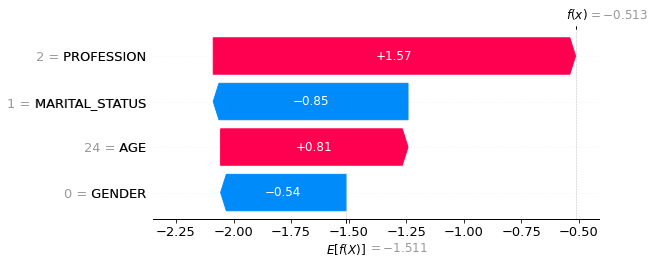

In [159]:
if local_explanations:
    shap.plots.waterfall(local_explanations[0])

The above explanation shows the features contributing to the model output from the base value (the average model output over the training data) to the model output of this data point. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue.

Another way to visualize the same explanation is to use a force plot. Using logit link shows the explanation in probability space.

In [160]:
if local_explanations:
    shap.plots.force(local_explanations[0], link="logit")

### Visualize the summary of explanations

To get an overview of which features are most important for a model we can plot the SHAP values of every feature for every sample. The plot below sorts features by the sum of SHAP value magnitudes over all samples, and uses SHAP values to show the distribution of the impacts each feature has on the model output. The color represents the feature value (red high, blue low). This reveals for example that a high MARITAL_STATUS value decreases the probability of Camping Equipment class

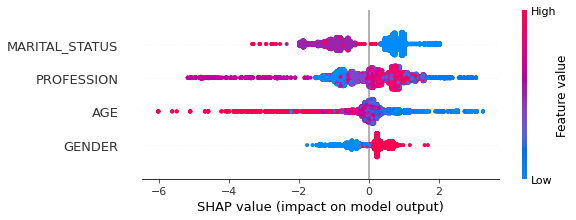

In [161]:
if local_explanations:
    shap.plots.beeswarm(local_explanations)

The generated global explanations(mean_abs or max_abs or mean_sq) could be plotted as a bar plot to understand the overall importance of features.

In the below plot the mean absolute shap values are plotted.

In [ ]:
global_explanations = shap_explanations.get("global")
if global_explanations:
    global_explanation = global_explanations.get("mean_abs")

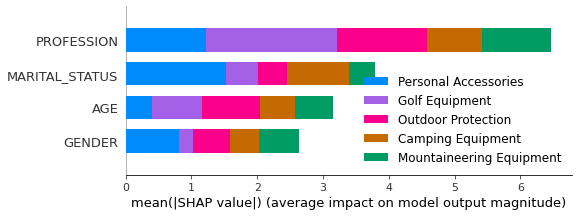

In [164]:
if global_explanations:
    shap.summary_plot(global_explanation, class_names=global_explanations.get("class_labels"))

To understand how a single feature effects the output of the model, the SHAP value of that feature and the value of the feature for all the datapoints could be plotted. Since SHAP values represent a feature's responsibility for a change in the model output, the plot below represents the change in output for class 0(Camping Equipment) as AGE changes. Vertical dispersion at a single value of AGE represents interaction effects with other features. When all the SHAP values are passed, the feature having the higher interaction would be picked up automatically if not specified.

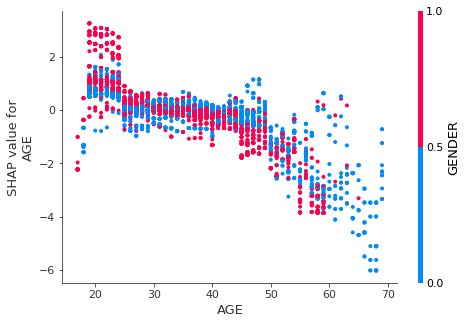

In [165]:
if local_explanations:
    shap.dependence_plot("AGE", local_explanations.values, local_explanations.data, feature_names=local_explanations.feature_names)

**Authors**

Developed by Pratap Kishore Varma V